In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer


import sys, os,  pickle, time

sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

# from datetime import datetime



In [2]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
proj_name = 'qt' # ['openstack','qt']



if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
if not os.path.exists(dump_dataframe_dir):
    os.makedirs(dump_dataframe_dir)
    
if not os.path.exists(pyExp_dir):
    os.makedirs(pyExp_dir)
    
if not os.path.exists(other_object_dir):
    os.makedirs(other_object_dir)

## Prepare data

In [3]:
x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')

In [4]:
# display(x_train)

In [5]:
# # print(y_train)
# for col in x_test.columns:
#     print(col,len(x_test[col].unique()))

col = list(x_test.columns)
# print(col)
# print(col.index('self'))

## Train global model

In [6]:
smt = SMOTE(k_neighbors=5, random_state=42, n_jobs=24)
# enn = EditedNearestNeighbours(n_neighbors=5, n_jobs=24)
# smt_tmk = SMOTETomek(smote = smt, random_state=0)
# smt_enn = SMOTEENN(smote=smt, enn=enn, random_state=0)

new_x_train, new_y_train = smt.fit_resample(x_train, y_train)

def train_global_model(x_train,y_train):
    global_model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=24)
    global_model.fit(x_train, y_train)

    pickle.dump(global_model, open(proj_name+'_global_model.pkl','wb'))
    print('train global model finished')
    
train_black_box = True

if train_black_box:
    train_global_model(new_x_train, new_y_train)

train global model finished


## Obtain correctly predicted defective commits

In [7]:
global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))
# x_test, y_test = prepare_data(proj_name, mode = 'test')

pred = global_model.predict(x_test)
defective_prob = global_model.predict_proba(x_test)[:,1]

prediction_df = x_test.copy()
prediction_df['pred'] = pred
prediction_df['defective_prob'] = defective_prob
prediction_df['defect'] = y_test

print('AUC is',roc_auc_score(y_test, defective_prob))
correctly_predict_df = prediction_df[(prediction_df['pred']==1) & (prediction_df['defect']==1)]

AUC is 0.7350656132213174


In [8]:
print(len(correctly_predict_df))
prediction_df.to_csv(dump_dataframe_dir+proj_name+'_prediction_result.csv')
correctly_predict_df.to_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')


79


## Training local model

Note: this step includes instance generation

In [9]:
print(correctly_predict_df.columns[:-3])

Index(['la', 'ld', 'nd', 'ns', 'ent', 'nrev', 'rtime', 'hcmt', 'self', 'ndev',
       'age', 'app', 'asexp', 'rsexp', 'asawr', 'rsawr'],
      dtype='object')


In [10]:
global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

load_prediction_from_file = True
class_label = ['clean', 'defect']

if load_prediction_from_file:
    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')
    
dep = 'defect'
indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

# print(correctly_predict_df.columns)
# print(len(correctly_predict_df.columns))
# print(indep)
# display(correctly_predict_df)

In [16]:
# for our apporach
pyExp = PyExplainer(x_train, y_train, indep, dep, global_model, class_label)

# for baseline
# note: 6 is index of 'self' feature
lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=[6], 
                                      feature_names=indep, class_names=class_label, 
                                      random_state=0)

In [17]:
feature_df = correctly_predict_df.loc[:, indep]
test_label = correctly_predict_df.loc[:, dep]
problem_index = [] # store index that cannot build pyExplainer

In [18]:
'''
    search function: lime or crossoverinterpolation
'''
def create_pyExplainer_obj(search_function, feature_df, test_label, explainer='LRR'):
    
    if search_function.lower() not in ['lime','crossoverinterpolation']:
        print('the search function must be "lime" or "crossoverinterpolation"')
        return
    
    problem_index = []
    time_spent = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        y_explain = test_label.iloc[[i]]

        row_index = str(X_explain.index[0])

        start = time.time()
        try:
            if search_function=='CrossoverInterpolation':
                # the returned object is dictionary
                pyExp_obj = pyExp.explain(X_explain,
                                           y_explain,
                                           search_function = search_function, 
                                           top_k = 1000,
                                           max_rules=2000, 
                                           max_iter = None, 
                                           cv=5,
                                           explainer=explainer,
                                           debug = False)
    #             synt_pred = pyExp_obj['synthetic_predictions']
                pyExp_obj['commit_id'] = row_index
        
                # because I don't want to change key name in another evaluation file
                pyExp_obj['local_model'] = pyExp_obj['local_rulefit_model']
                del pyExp_obj['local_rulefit_model']
    #             print('{}: found {} defect from total {}'.format(row_index, str(np.sum(synt_pred)), 
    #                                                          str(len(synt_pred))))
                pickle.dump(pyExp_obj, open(pyExp_dir+proj_name+'_'+explainer+'_'+search_function.lower()+'_'+row_index+'.pkl','wb'))
        
            else:
                X_explain = feature_df.iloc[i] # to prevent error in LIME
                exp, synt_inst, synt_inst_for_local_model, selected_feature_indices, local_model = lime_explainer.explain_instance(X_explain, global_model.predict_proba)

                lime_obj = {}
                lime_obj['rule'] = exp
                lime_obj['synthetic_instance_for_global_model'] = synt_inst
                lime_obj['synthetic_instance_for_lobal_model'] = synt_inst_for_local_model
                lime_obj['local_model'] = local_model
                lime_obj['selected_feature_indeces'] = selected_feature_indices
                lime_obj['commit_id'] = row_index
                pickle.dump(lime_obj, open(pyExp_dir+proj_name+'_lime_'+row_index+'.pkl','wb'))
                
            print('finished',row_index)
#             print(row_index)
#             print('just one rulefit is enough')
            break
            
        except Exception as e:
            problem_index.append(row_index)
            print('-'*100)
            print(e)
#             print('found total {} problematic commit'.format(str(len(problem_index))))
            print('-'*100)
            
#         break

        end = time.time()

        time_spent.append(str(end-start))
#     print(row_index)
#     break
    
    print('from total {} commits, there are {} problematic commits'.format(len(feature_df),len(problem_index)))
    return time_spent, problem_index

In [28]:
# time_spent_rand, problem_index_rand = create_pyExplainer_obj('randompertubation', feature_df, test_label,'LRR')
# pickle.dump(time_spent_rand, open(other_object_dir+proj_name+'_train_time_LRR_randompertubation.pkl','wb'))
# pickle.dump(problem_index_rand, open(other_object_dir+proj_name+'_problem_index_LRR_randompertubation.pkl','wb'))

time_spent_rand, problem_index_rand = create_pyExplainer_obj('lime', feature_df, test_label,'rulefit')
pickle.dump(time_spent_rand, open(other_object_dir+proj_name+'_train_time_lime.pkl','wb'))
pickle.dump(problem_index_rand, open(other_object_dir+proj_name+'_problem_index_lime.pkl','wb'))

finished f5dbc876378ae58a7bdfe1e9664fc81caca18dfb
finished 602bd9873786ccadcb67da3036329f3122555cf8
finished 9d75626b1073113d77988bcb52e99215d5af4787
finished 3168c94577cc604fd033ce4e741da5c411f74666
finished 23bdca417bde716c79168ab372083fd885607123
finished 438211ec627073817fcaf6d3a07b76f2aa5d90e0
finished d8090022f66cc6cff6af5ed2ae702212fd172ff7
finished 06eaeb0ac8d861cf3e60b11a8fbbabdeef1d6759
finished 4dbf574b7acb7ae8f852219700afa95f8d568f0e
finished 2eb28f51ce4150fa03b2ddde8c39b502ae57d18a
finished 61b56a89a1cf8a388ff925492700e5eef019c3aa
finished 07860794da5863610f38295c9d517fc457c5de95
finished b508dc98a5085df6ea44b154177fbb6d8b0e8434
finished b449791c3565940e701c68b3f705014804af0c2b
finished 3abecf2ee9fc724af571f8c7da4302f7bee9eadb
finished d8d903826daa8db49e437b76fb80693ab8feb01e
finished 5b456c8da4462f9e11fa4da78a9e6ea86423a1e8
finished 37ca2224eca671200a2710f57f970d2993e62aa5
finished fd619946be51784dc709363324897be6af144c52
finished 0ed9f7496656fa0ea52d703c7fddff26c2192857


In [19]:
# time_spent_ci, problem_index_ci = create_pyExplainer_obj('crossoverinterpolation', feature_df, test_label)
# pickle.dump(time_spent_ci, open(other_object_dir+proj_name+'_train_time_LRR_crossoverinterpolation.pkl','wb'))
# pickle.dump(problem_index_ci, open(other_object_dir+proj_name+'_problem_index_LRR_crossoverinterpolation.pkl','wb'))

time_spent_ci, problem_index_ci = create_pyExplainer_obj('crossoverinterpolation', feature_df, test_label,'rulefit')
pickle.dump(time_spent_ci, open(other_object_dir+proj_name+'_train_time_rulefit_crossoverinterpolation.pkl','wb'))
pickle.dump(problem_index_ci, open(other_object_dir+proj_name+'_problem_index_rulefit_crossoverinterpolation.pkl','wb'))

finished f5dbc876378ae58a7bdfe1e9664fc81caca18dfb
from total 79 commits, there are 0 problematic commits


## Just for testing

In [23]:
explainer = 'rulefit'
pyExp_random = pickle.load(open(pyExp_dir+proj_name+'_'+explainer+'_randompertubation_3126.pkl','rb'))
pyExp_crossover = pickle.load(open(pyExp_dir+proj_name+'_'+explainer+'_crossoverinterpolation_3126.pkl','rb'))

In [25]:
print(pyExp_random.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'local_model', 'top_k_positive_rules', 'top_k_negative_rules'])


In [32]:
# euclid_dist = euclidean_distances(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]

dist_rand = euclidean_distances(pyExp_random['X_explain'].values.reshape(1,-1), pyExp_random['synthetic_data'].values)[0]
# plt.boxplot(dist)

In [33]:
dist_cross = euclidean_distances(pyExp_crossover['X_explain'].values.reshape(1,-1), pyExp_crossover['synthetic_data'].values)[0]
# plt.boxplot(dist)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f991f275760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f991f26bc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f991f275d30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f991f265a30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f991f265c10>,
 'means': []}

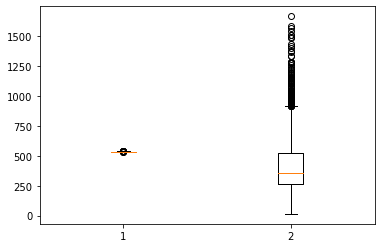

In [34]:
data = [dist_rand, dist_cross]
plt.boxplot(data)

In [16]:
# display(feature_df)
# for c in feature_df:
#     print(c)

# for k in range(0,1):
#     print(k)

In [17]:
# test feature binarizer
# from pyexplainer.features import *
# fb = FeatureBinarizer(negations=True)
# fb.fit(x_train)
# display(fb.transform(feature_df))

In [18]:
# search_function='randompertubation'
# i = 3

# X_explain = feature_df.iloc[[i]]
# y_explain = test_label.iloc[[i]]

# row_index = str(X_explain.index[0])

# start = time.time()

# pyExp_obj = pyExp.explain(X_explain,
#                            y_explain,
#                            search_function = search_function, 
#                            top_k = 1000,
#                            max_rules=2000, 
#                            max_iter =None, 
#                            cv=5,
#                            explainer='rulefit',
#                            debug = False)

In [19]:
print(pyExp_obj.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'local_model', 'top_k_positive_rules', 'top_k_negative_rules'])


In [24]:
# display(pyExp_obj['synthetic_data_fb'])

In [23]:
# local_model = pyExp_obj['local_model']
# print(local_model.predict(X_explain.values))
# print('------------------Explanation from local model-------------------------')
# print(local_model.explain())

[False]


In [11]:
# display(pyExp_obj['X_explain'])

In [12]:
# print(local_model.predict(pyExp_obj['X_explain_fb']))

### sample code for RQ1

In [26]:
# synthetic_instances = pyExp_obj['synthetic_data']
# sample_instance = pyExp_obj['X_explain']

In [23]:
# def agg_list(val):
#     return np.mean(val), np.median(val), np.max(val)

# cos_sim = cosine_similarity(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]
# euclid_dist = euclidean_distances(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]

### sample code for RQ2

In [35]:
# '''get prediction from global model then compare with result obtained from model (but how to compare??)'''

# local_model = pyExp_obj['local_model']
# '''In case pyExp uses logistic rule regression'''
# fb_sample_instance = pyExp.feature_binarizer.transform(sample_instance)
# # print(pyExp.feature_binarizer.transform(sample_instance))
# local_pred = local_model.predict(fb_sample_instance)
# local_pred_prob = local_model.predict_proba(fb_sample_instance)

# '''In case pyExp uses RuleFit'''
# # local_pred = local_model.predict(sample_instance)
# # local_pred_prob = local_model.predict_proba(sample_instance)

# print(local_pred, local_pred_prob)

[False] [0.06562197]


In [13]:
# test rulefit
search_function='randompertubation'
print('------------------Prediction from local model-------------------------')
for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='LRR',
                                   debug = False)
        end = time.time()
#         print('time spent to train LRR:',str(end-start),'secs')
        
        local_model = pyExp_obj['local_model']
        print(local_model.explain())
        
#         print(global_model.predict_proba(X_explain)[:,1], local_model.predict_proba(pyExp.scaler.transform(X_explain.values))[:,1])
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)


------------------Prediction from local model-------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)    0.926494
1  nrev <= 1.00  -11.265911
2    nd <= 1.00   -3.340535
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)   -4.822969
1   nrev <= 1.00  -21.790036
2    ent <= 0.90    11.04842
3  asawr <= 0.16    2.480303
4    nuc <= 3.00    2.480303
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)   -9.127939
1  nrev <= 2.00   12.185013
2  nrev <= 1.00   -7.495421
3   ent <= 0.63   -7.495421
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
there is only 1 class in the generated instances
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)    0.721183
1   nrev <= 1.00   -8.482928
2  asawr <= 0.05   -7.399822
----------------------------------------------------------------------------------------------------
          rule coefficient
0  (intercept)   -3.748032
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)   -9.149672
1  nrev <= 2.00   14.773528
2  nrev <= 1.00    -9.91744
3   ent <= 0.00   -8.247625
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)  -10.434791
1   nrev <= 1.00  -15.862358
2  asawr <= 0.09   15.725896
----------------------------------------------------------------------------------------------------
          rule coefficient
0  (intercept)   -2.933625
----------------------------------------------------------------------------------------------------
            rule coefficient
0    (intercept)    1.111113
1     ld <= 0.00  -11.000013
2   nrev <= 1.00   -2.505401
3  asawr <= 0.00   -0.249322
4  asawr <= 0.00   -0.249322
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [23]:
# test rulefit
search_function='crossoverinterpolation'
print('------------------Prediction from local model-------------------------')
for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='rulefit',
                                   debug = False)
        end = time.time()
#         print('time spent to train LRR:',str(end-start),'secs')
        
        local_model = pyExp_obj['local_model']
        
        print(global_model.predict_proba(X_explain)[:,1], local_model.predict_proba(X_explain.values)[:,1])
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)


------------------Prediction from local model-------------------------
[0.84] [0.96695341]
----------------------------------------------------------------------------------------------------
[0.73] [0.49372837]
----------------------------------------------------------------------------------------------------
[0.83] [0.99548978]
----------------------------------------------------------------------------------------------------
[0.67] [0.93530316]
----------------------------------------------------------------------------------------------------
[0.6] [0.94639136]
----------------------------------------------------------------------------------------------------
[0.66] [0.94685406]
----------------------------------------------------------------------------------------------------
[0.62] [0.77372941]
----------------------------------------------------------------------------------------------------
[0.75] [0.91593334]
---------------------------------------------------------------

In [14]:
import warnings
warnings.simplefilter("ignore")

In [30]:
# sample LRR when used with random perturbation

search_function='randompertubation'

for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='LRR',
                                   debug = False)
        end = time.time()
        print('time spent to train LRR:',str(end-start),'secs')

#         local_model = pyExp_obj['local_model']
#         print('------------------Explanation from local model-------------------------')
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)
    

time spent to train LRR: 1.4275202751159668 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.738269329071045 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.0873517990112305 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 0.9002327919006348 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.3496229648590088 secs
----------------------------------------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [31]:
# sample LRR when used with crossover interpolation

search_function='crossoverinterpolation'

for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    pyExp_obj = pyExp.explain(X_explain,
                               y_explain,
                               search_function = search_function, 
                               top_k = 1000,
                               max_rules=2000, 
                               max_iter =None, 
                               cv=5,
                               explainer='LRR',
                               debug = False)
    end = time.time()
    print('time spent to train LRR:',str(end-start),'secs')
    
#     local_model = pyExp_obj['local_model']
#     print('------------------Explanation from local model-------------------------')
#     print(local_model.explain())
    print('-'*100)
    
    

time spent to train LRR: 28.87514853477478 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 26.213839769363403 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 25.021041870117188 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 29.421844244003296 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 26.97343945503235 secs
----------------------------------------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [19]:
print(pyExp_obj.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'X_explain_fb', 'indep', 'dep', 'local_model'])


In [20]:
# display(pyExp_obj['synthetic_data'].columns)
# print(feature_df.index)
local_model = pyExp_obj['local_model']

In [21]:
print(local_model.explain( maxCoeffs=None))
# print(local_model.z)

          rule coefficient
0  (intercept)     1.21719
1  la <= 44.00    -2.10262
2  la <= 76.00   -0.561556


In [22]:
generated_instance = pyExp_obj['synthetic_data']
print(generated_instance.columns)
display(generated_instance)

MultiIndex([(   'la', '<=',                 1.0),
            (   'la', '<=',                 2.0),
            (   'la', '<=',                 5.0),
            (   'la', '<=',                 9.0),
            (   'la', '<=',                17.0),
            (   'la', '<=',                27.0),
            (   'la', '<=',                44.0),
            (   'la', '<=',                76.0),
            (   'la', '<=',               163.0),
            (   'ld', '<=',                 0.0),
            ...
            ('asawr', '<=',   0.433364602876798),
            ('rsawr', '<=', 0.18055330452007923),
            ('rsawr', '<=',  0.2564102564102564),
            ('rsawr', '<=',  0.3196254791765793),
            ('rsawr', '<=',  0.3754889178617992),
            ('rsawr', '<=',  0.4287529047714299),
            ('rsawr', '<=',  0.4816326530612245),
            ('rsawr', '<=',  0.5758975125536251),
            ('rsawr', '<=',  0.7078384798099763),
            ('rsawr', '<=',  0.848

feature           la                                                         \
operation         <=                                                          
value     1.000000   2.000000   5.000000   9.000000   17.000000  27.000000    
0                  0          0          0          0          0          0   
1                  0          0          0          0          0          0   
2                  0          0          0          0          0          0   
3                  0          0          0          0          0          0   
4                  0          0          0          0          0          1   
...              ...        ...        ...        ...        ...        ...   
2116               1          1          1          1          1          1   
2117               0          0          0          0          0          0   
2118               0          0          0          0          0          0   
2119               1          1          1          1          1          1   
2120               0          0          0          0          0          0   

feature                                            ld  ...      asawr  \
operation                                          <=  ...         <=   
value     44.000000  76.000000  163.000000 0.000000    ... 0.433365     
0                  0          0          0          0  ...          1   
1                  0          0          0          1  ...          1   
2                  0          0          0          0  ...          1   
3                  0          0          0          0  ...          1   
4                  1          1          1          0  ...          1   
...              ...        ...        ...        ...  ...        ...   
2116               1          1          1          0  ...          1   
2117               0          0          1          0  ...          1   
2118               1          1          1          1  ...          1   
2119               1          1          1          0  ...          1   
2120               0          0          0          0  ...          1   

feature        rsawr                                                         \
operation         <=                                                          
value     0.180553   0.256410   0.319625   0.375489   0.428753   0.481633     
0                  0          0          0          0          0          0   
1                  0          0          0          0          0          0   
2                  0          0          0          0          0          0   
3                  0          0          0          0          0          0   
4                  0          0          0          0          0          0   
...              ...        ...        ...        ...        ...        ...   
2116               0          0          0          0          0          1   
2117               1          1          1          1          1          1   
2118               0          0          0          0          0          0   
2119               0          0          0          0          0          0   
2120               1          1          1          1          1          1   

feature                                     
operation                                   
value     0.575898   0.707838   0.848712    
0                  0          1          1  
1                  0          1          1  
2                  1          1          1  
3                  0          1          1  
4                  0          1          1  
...              ...        ...        ...  
2116               1          1          1  
2117               1          1          1  
2118               0          1          1  
2119               0          0          1  
2120               1          1          1  

[2121 rows x 165 columns]

In [41]:
print(generated_instance.loc[:, (generated_instance.columns.get_level_values(0)=='la') & 
                            (generated_instance.columns.get_level_values(1)=='<=') &
                            (generated_instance.columns.get_level_values(2)==44.0)  ])

feature     la
operation   <=
value     44.0
0            0
1            0
2            0
3            0
4            1
...        ...
2116         1
2117         0
2118         1
2119         1
2120         0

[2121 rows x 1 columns]


In [23]:
# # search_function = 'crossoverinterpolation' # 'randompertubation' or 'crossoverinterpolation'
# search_functions = ['randompertubation', 'crossoverinterpolation']

# for i in range(0,len(feature_df)):
#     X_explain = feature_df.iloc[[i]]
#     y_explain = test_label.iloc[[i]]
    
#     row_index = str(X_explain.index[0])
    
#     try:
#         pyExp_obj = pyExp.explain(X_explain,
#                                    y_explain,
#                                    search_function = search_function, 
#                                    top_k = 1000, 
#                                    max_rules=2000, 
#                                    max_iter =None, 
#                                    cv=5,
#                                    debug = False)
#         pickle.dump(pyExp_obj, open(pyExp_dir+search_function+'_'+row_index+'.pkl','wb'))
        
#         synt_pred = pyExp_obj['synthetic_predictions']
#         print('{}: found {} defect from total {}'.format(row_index, str(np.sum(synt_pred)), 
#                                                          str(len(synt_pred))))
# #         print('finished', row_index)
#     except:
#         problem_index.append(row_index)
# #     print(row_index)
#     break

In [24]:
# explain_index = 13
# X_explain = feature_df.iloc[[explain_index]]
# X_explain

In [25]:
# y_explain = test_label.iloc[[explain_index]]
# y_explain

In [26]:
# search_function = 'crossoverinterpolation' # 'randompertubation' or 'crossoverinterpolation''
# start = time.time()
# create_pyExp_rule_obj = pyExp.explain(X_explain,
#                                y_explain,
#                                search_function = search_function, 
#                                top_k = 1000, 
#                                max_rules=2000, 
#                                max_iter =None, 
#                                cv=5,
#                                debug = False)

# end = time.time()

In [27]:
# print('time spent {}'.format(str(end-start)))
# pickle.dump(create_pyExp_rule_obj, open(pyExp_dir+search_function+'_'+str(explain_index)+'.pkl','wb'))

In [28]:
# display(create_pyExp_rule_obj['synthetic_data'])

In [29]:
# # print(create_pyExp_rule_obj['synthetic_predictions'])
# # print(np.sum(create_pyExp_rule_obj['synthetic_predictions']))
# display(create_pyExp_rule_obj.keys())
# print(create_pyExp_rule_obj['synthetic_predictions'])